In [1]:
import os
import pywt
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
from pandas import DataFrame
from pandas import concat#相空间重构用到的包
import seaborn as sns
from scipy.stats import pearsonr
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#导入csv文件
df=pd.read_csv(r'D:\article\2023年2月-2024年1月吉林数据.csv',encoding="ANSI")
names=df.columns#查看列名
df

date_time     power  windspeed        tem        hum     pressure  \
0       2/1 0h  0.000000   1.085845 -10.089270  83.874551   990.751875   
1       2/1 1h  0.000000   1.626503  -9.719397  83.912789   991.142812   
2       2/1 2h  0.000000   1.868444  -9.852789  85.232426   991.576016   
3       2/1 3h  0.000000   1.905517  -9.233160  82.964424   991.517266   
4       2/1 4h  0.000000   1.818337  -8.989111  83.857947   992.222109   
...        ...       ...        ...        ...        ...          ...   
8755  1/31 19h  0.105971   4.545420 -16.976721  52.390439  1009.258906   
8756  1/31 20h  0.111731   4.622429 -16.860358  50.413962  1009.085313   
8757  1/31 21h  0.114622   4.653930 -18.009726  52.755465  1009.015625   
8758  1/31 22h  0.142834   5.009038 -19.618597  53.572450  1009.216016   
8759  1/31 23h  0.184980   5.390989 -19.969519  53.545448  1010.083828   

      precipitation    wind_dir  
0          0.042239  308.593720  
1          0.077074  311.958344  
2          0.193527  324.966583  
3          0.160207  338.609619  
4          0.130588  354.327820  
...             ...         ...  
8755       0.000029  262.499878  
8756       0.000029  257.921448  
8757       0.000029  255.266907  
8758       0.000029  253.332748  
8759       0.000029  260.195953  

[8760 rows x 8 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


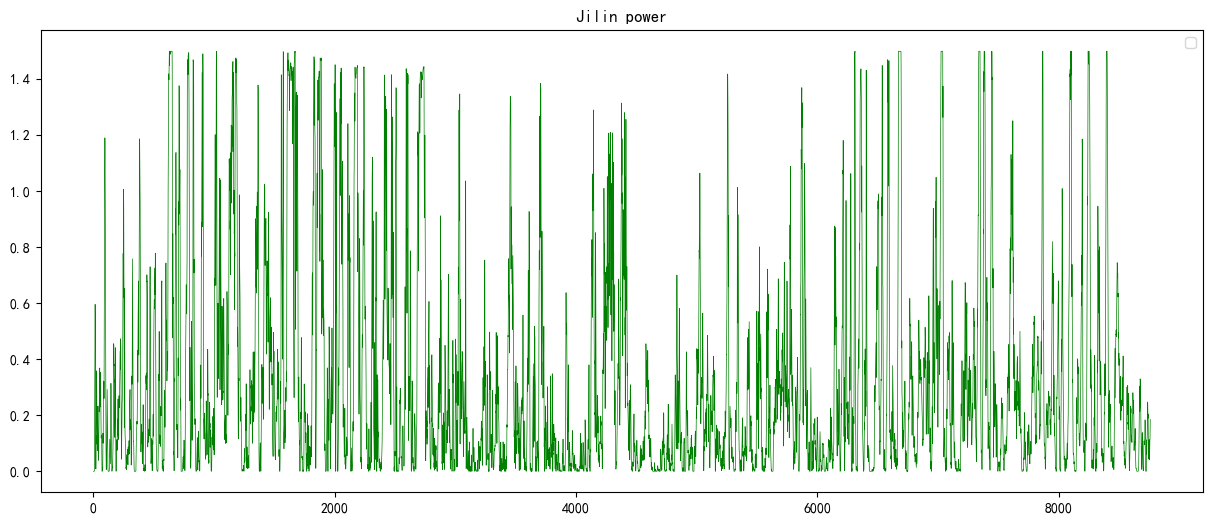

In [3]:
#对海南风功率原始进行可视化
plt.figure(figsize=(15,6))
plt.plot(df["power"],color='green', linewidth=0.5)
plt.title("Jilin power")
plt.legend()
plt.show()

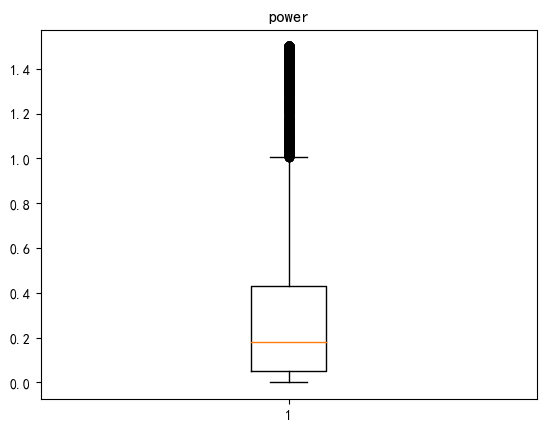

In [4]:
import matplotlib.pyplot as plt
# 显示图表
plt.subplot(1,1,1)
plt.boxplot(df["power"])
plt.title("power")
plt.show()

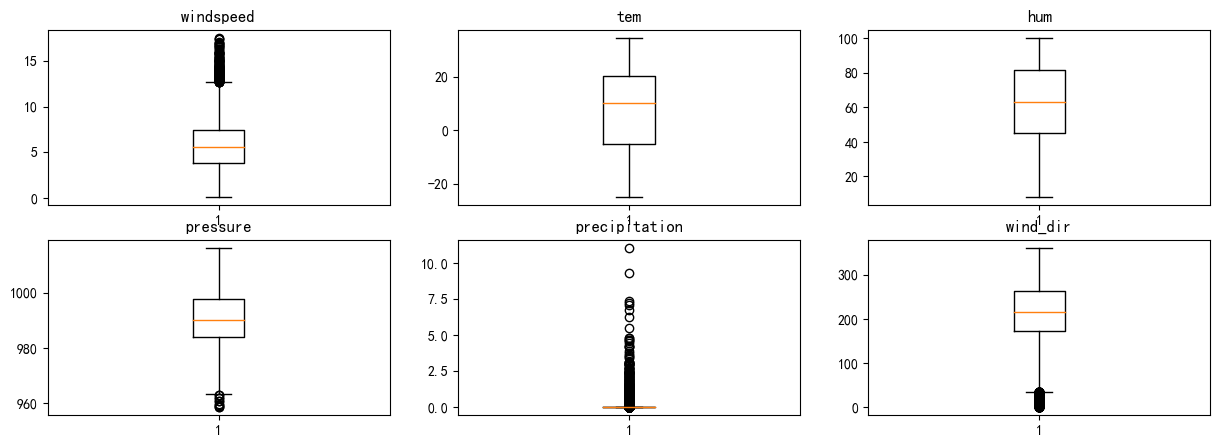

In [5]:
#异常值检测
fig,axs=plt.subplots(2,3,figsize=(15,5))
axs[0,0].boxplot(df["windspeed"])
axs[0,0].set_title('windspeed')
axs[0,1].boxplot(df["tem"])
axs[0,1].set_title('tem')
axs[0,2].boxplot(df["hum"])
axs[0,2].set_title('hum')
axs[1,0].boxplot(df["pressure"])
axs[1,0].set_title('pressure')
axs[1,1].boxplot(df["precipitation"])
axs[1,1].set_title('precipitation')
axs[1,2].boxplot(df["wind_dir"])
axs[1,2].set_title('wind_dir')
plt.show()

Text(0.5, 1.0, 'power')

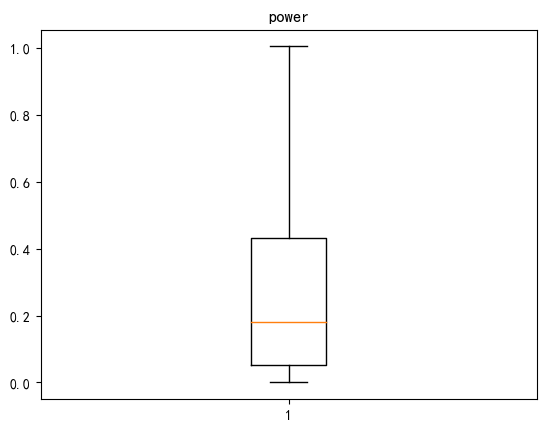

In [6]:
#处理异常值(box-plot-四分数法)
Q=df['power'].quantile([0.25,0.5,0.75])
Q1=df['power'].quantile(0.25)
Q2=df['power'].quantile(0.5)
Q3=df['power'].quantile(0.75)
IQR=Q3-Q1
#计算上下限
up=Q3+1.5*IQR
lw= Q1-1.5*IQR
newdata=[lw if x< lw else x for x in df['power']]
new_power=[up if x> up else x for x in newdata]#将数据集中在上下界，用lw替换下界，用up替换上界
#处理异常值之后的风速数据
plt.subplot(1,1,1)
plt.boxplot(new_power)
plt.title("power")

In [7]:
# 计算四分位数
Q1 = df["power"].quantile(0.25)
Q2 = df["power"].quantile(0.5)
Q3 = df["power"].quantile(0.75)

# 打印四分位数
print("第一四分位数 (Q1):", Q1)
print("中位数 (Q2, 即第二四分位数):", Q2)
print("第三四分位数 (Q3):", Q3)

第一四分位数 (Q1): 0.05116924375
中位数 (Q2, 即第二四分位数): 0.1819391635
第三四分位数 (Q3): 0.4326784065


In [8]:
# 获取最大值
max_power = df["power"].max()

# 打印最大值
print("最大值:", max_power)

最大值: 1.5


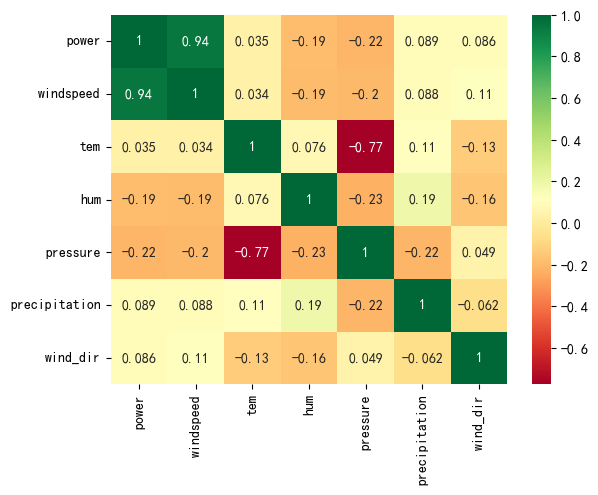

In [9]:
##对影响因素进行分析
#绘制热力图表明各变量之间的相关性
person=df[['power','windspeed','tem','hum','pressure','precipitation','wind_dir']]
#使用numpy来求皮尔森相关系数
cor_1=np.corrcoef(person,rowvar=False)#rowvar=False时计算的是列与列之间(即随机变量)的相关性
X1=pd.DataFrame(df,names)
x_ticks = ['power','windspeed','tem','hum','pressure','precipitation','wind_dir']
y_ticks = ['power','windspeed','tem','hum','pressure','precipitation','wind_dir']
ax=sns.heatmap(cor_1,xticklabels=x_ticks, yticklabels=y_ticks,vmax=1,cmap='RdYlGn',annot=True)
plt.show()
#结果表明，风功率与风速、温度、压强、风向关系较为密切

In [10]:
#为了方便处理，将数据框第一列删除
# 假设df是已经存在的DataFrame
df = df.drop(['date_time','tem','precipitation','wind_dir'], axis=1)
df

power  windspeed        hum     pressure
0     0.000000   1.085845  83.874551   990.751875
1     0.000000   1.626503  83.912789   991.142812
2     0.000000   1.868444  85.232426   991.576016
3     0.000000   1.905517  82.964424   991.517266
4     0.000000   1.818337  83.857947   992.222109
...        ...        ...        ...          ...
8755  0.105971   4.545420  52.390439  1009.258906
8756  0.111731   4.622429  50.413962  1009.085313
8757  0.114622   4.653930  52.755465  1009.015625
8758  0.142834   5.009038  53.572450  1009.216016
8759  0.184980   5.390989  53.545448  1010.083828

[8760 rows x 4 columns]

In [11]:
#将数据划分为四季（按实际意义划分）
import pandas as pd
spring= df.iloc[744:2880]  # 注意索引是从0开始的，所以234行实际上是索引233
summer=df.iloc[2880:5088]
autumn=df.iloc[5088:7296]
winter_1=df.iloc[7296:8760]
winter_2=df.iloc[1:744]
# 合并两个选取的行到一个新的数据框
winter = pd.concat([winter_1, winter_2], ignore_index=True)

In [12]:
#将数据框分为训练集和测试集
from sklearn.model_selection import train_test_split
train_spring, test_spring = train_test_split(spring, test_size=0.2, random_state=42,shuffle=False)
train_summer, test_summer = train_test_split(summer, test_size=0.2, random_state=42,shuffle=False)
train_autumn, test_autumn = train_test_split(autumn, test_size=0.2, random_state=42,shuffle=False)
train_winter, test_winter = train_test_split(winter, test_size=0.2, random_state=42,shuffle=False)

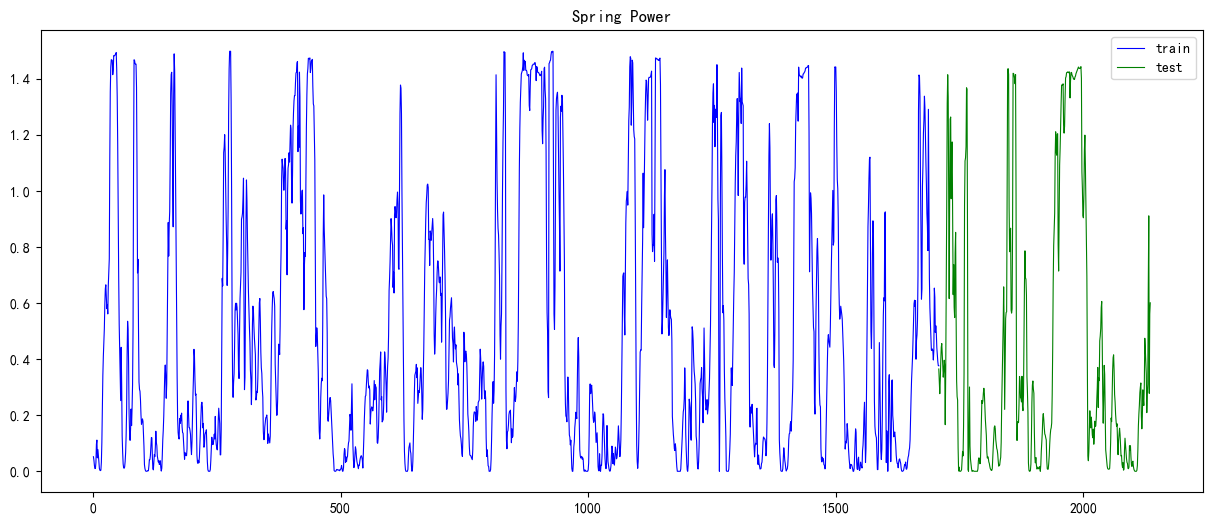

In [13]:
#对春天的训练集和测试集进行可视化
t1_1=range(1,len(train_spring)+1)
t1_2=range(len(train_spring),len(spring))
plt.figure(figsize=(15,6))
plt.plot(t1_1,train_spring["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t1_2,test_spring["power"],color='green', linewidth=0.8,label='test')
plt.title("Spring Power")
plt.legend()
plt.show()

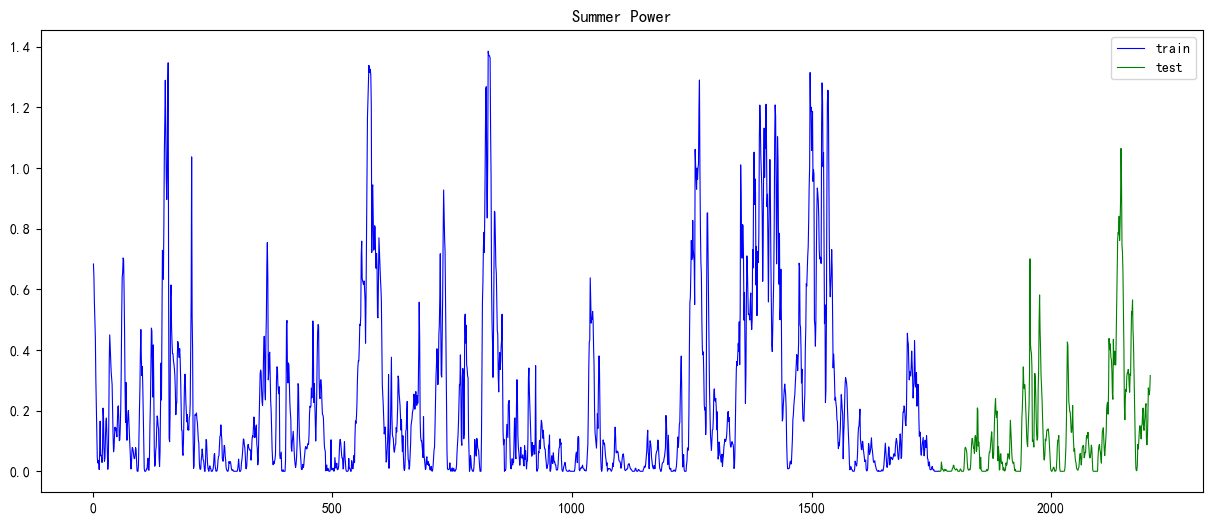

In [14]:
#对夏天的训练集和测试集进行可视化
t2_1=range(1,len(train_summer)+1)
t2_2=range(len(train_summer),len(summer))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_summer["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_summer["power"],color='green', linewidth=0.8,label='test')
plt.title("Summer Power")
plt.legend()
plt.show()

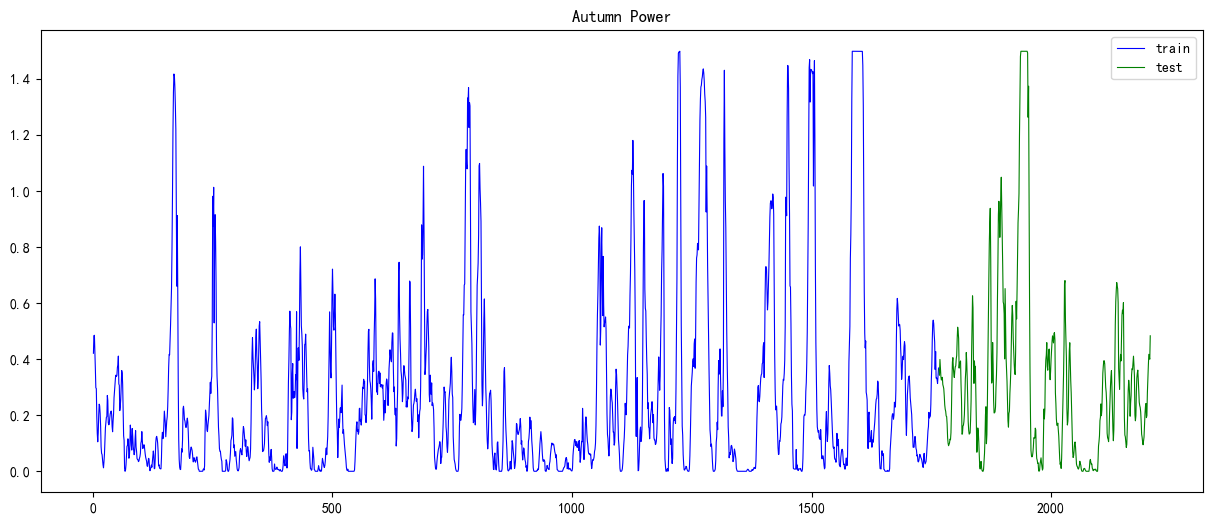

In [15]:
#对秋天的训练集和测试集进行可视化
t2_1=range(1,len(train_autumn)+1)
t2_2=range(len(train_autumn),len(autumn))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_autumn["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_autumn["power"],color='green', linewidth=0.8,label='test')
plt.title("Autumn Power")
plt.legend()
plt.show()

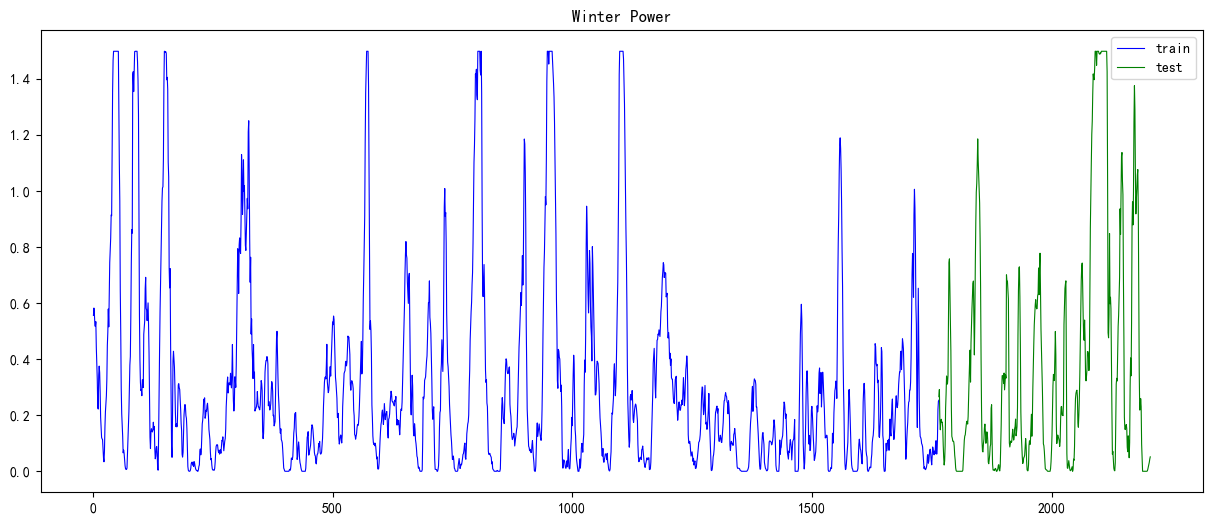

In [16]:
#对冬天的训练集和测试集进行可视化
t2_1=range(1,len(train_winter)+1)
t2_2=range(len(train_winter),len(winter))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_winter["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_winter["power"],color='green', linewidth=0.8,label='test')
plt.title("Winter Power")
plt.legend()
plt.show()

In [17]:
#对训练集和测试集分别进行归一化，以防数据泄露
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# 实例化 MinMaxScaler
scaler = MinMaxScaler()
# 使用 MinMaxScaler 进行归一化
scaler_train_spring = scaler.fit_transform(train_spring)
scaler_test_spring = scaler.fit_transform(test_spring)
scaler_train_summer = scaler.fit_transform(train_summer)
scaler_test_summer = scaler.fit_transform(test_summer)
scaler_train_autumn = scaler.fit_transform(train_autumn)
scaler_test_autumn = scaler.fit_transform(test_autumn)
scaler_train_winter = scaler.fit_transform(train_winter)
scaler_test_winter = scaler.fit_transform(test_winter)

In [18]:
####第一种定义识别坡道

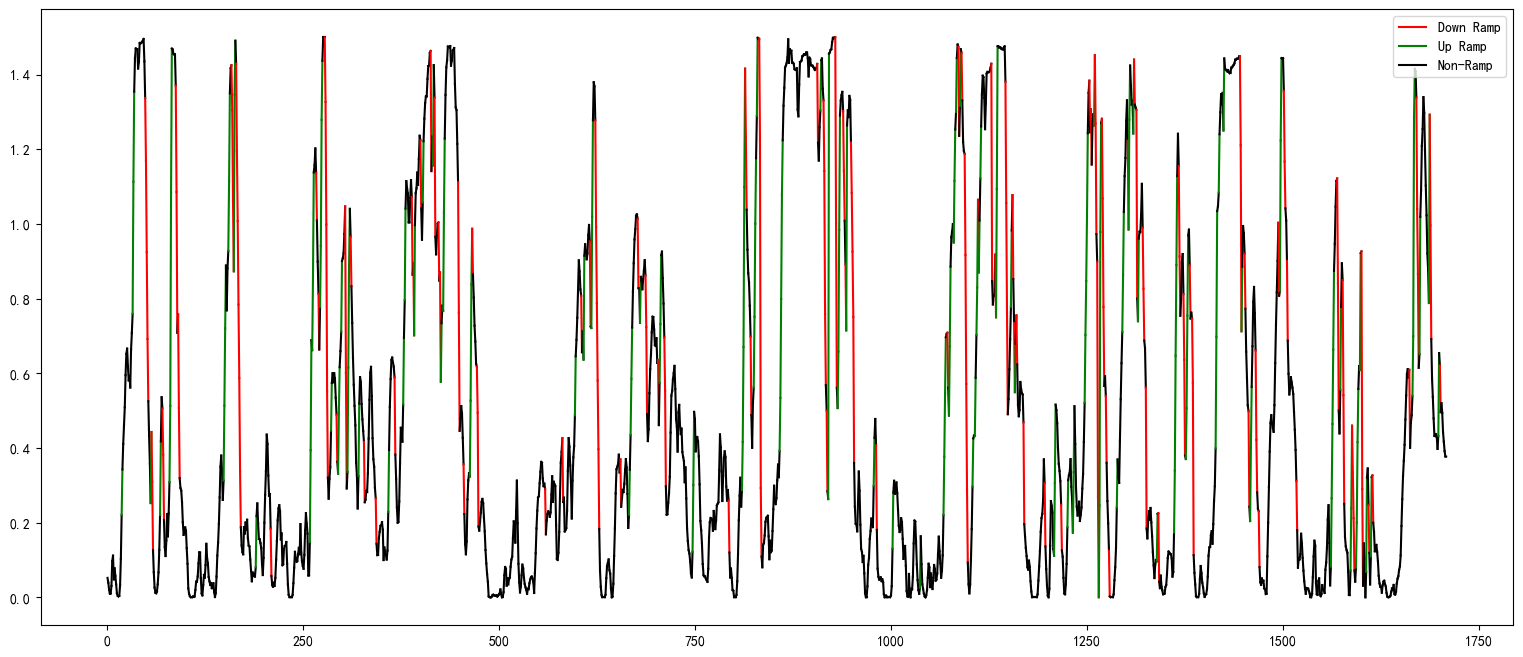

绿色线段数量: 151
红色线段数量: 160


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
spring_power = train_spring["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ct1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ct1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ct1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ct1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_ct1 = fit_line(spring_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct1)

In [20]:
#####第二种定义识别坡道段

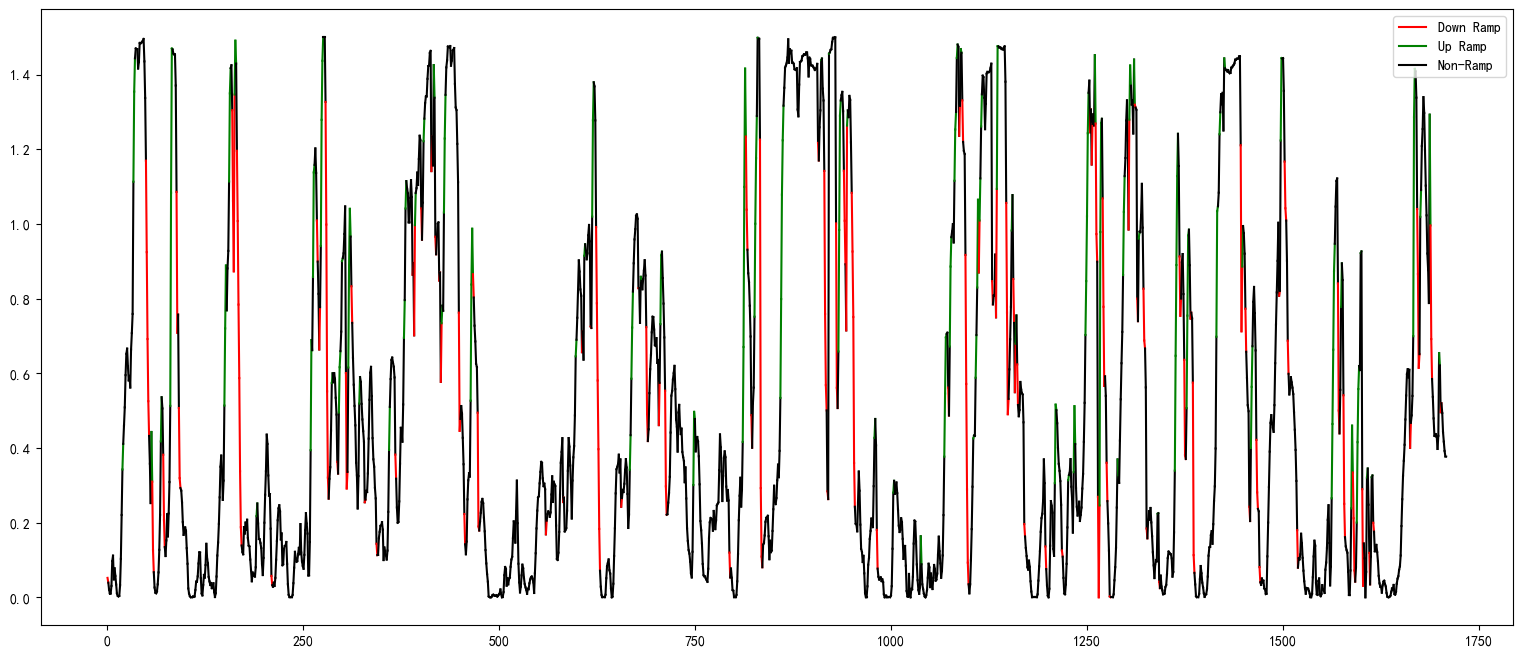

绿色线段数量: 151
红色线段数量: 161


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spring_power = train_spring["power"]

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []# 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_ct2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_ct2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ct2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_ct2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct2

threshold = 0.12
# 调用函数并获取颜色计数

green_count, red_count,labels_ct2 = fit_line(spring_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct2)

In [22]:
#第三种定义识别坡道

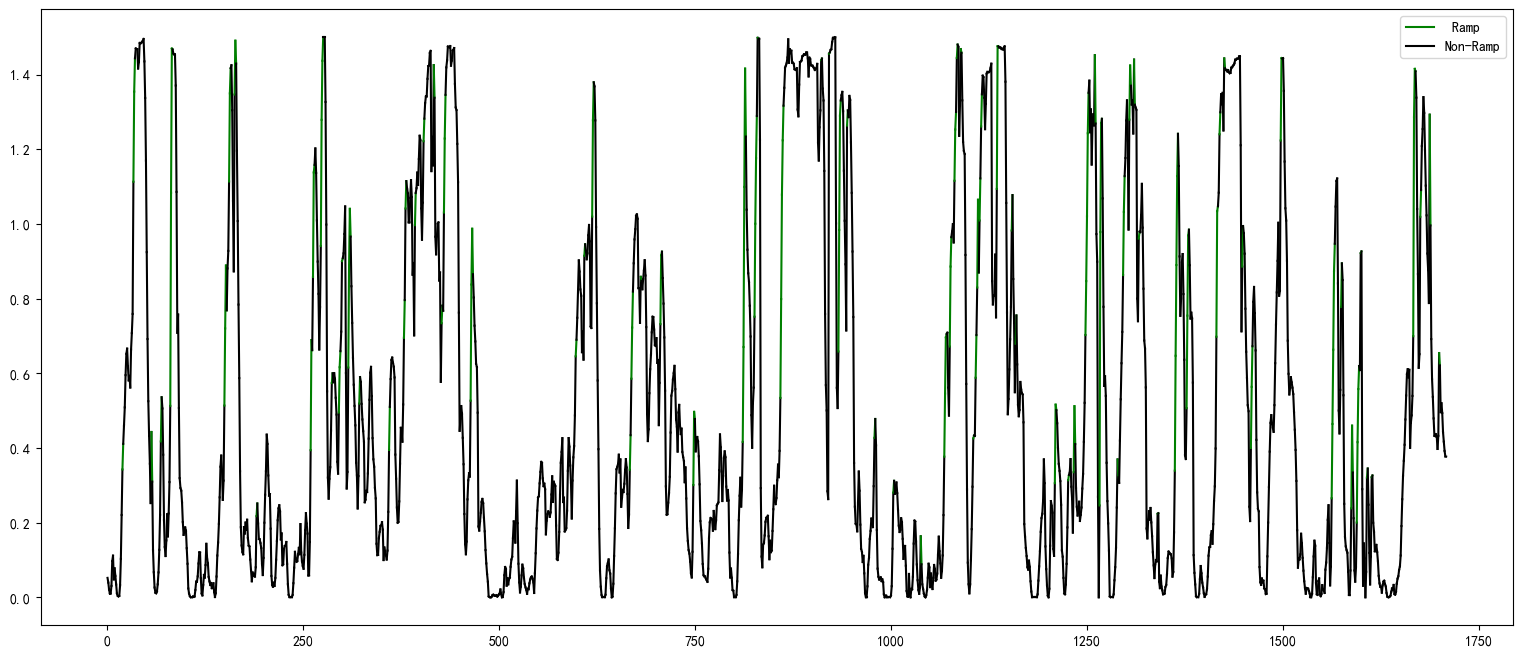

绿色线段数量: 151
红色线段数量: 0


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spring_power = train_spring["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(spring_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_ct3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_ct3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_ct3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label=' Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_ct3 = fit_line(spring_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct3)

In [24]:
###对夏天的数据进行坡道检测

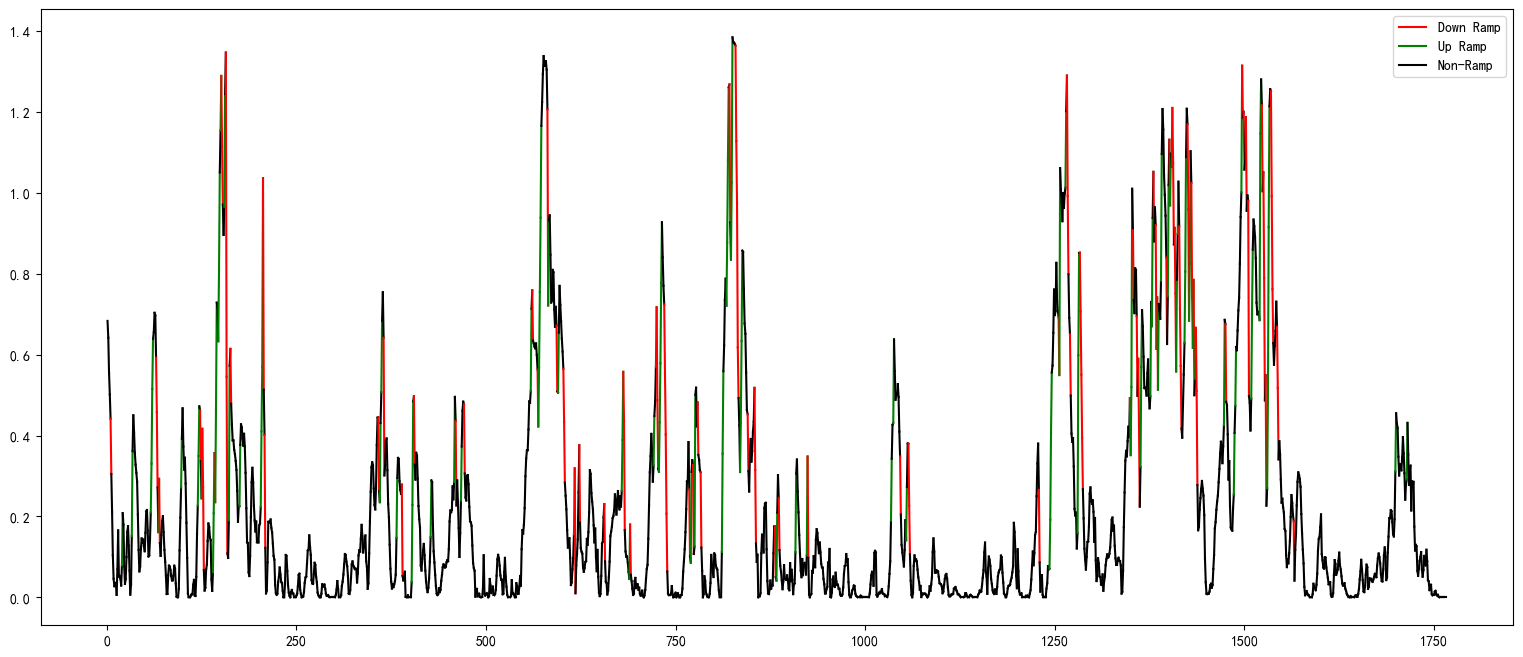

绿色线段数量: 106
红色线段数量: 105


In [25]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
summer_power = train_summer["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_xt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_xt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_xt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_xt1 = fit_line(summer_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt1)

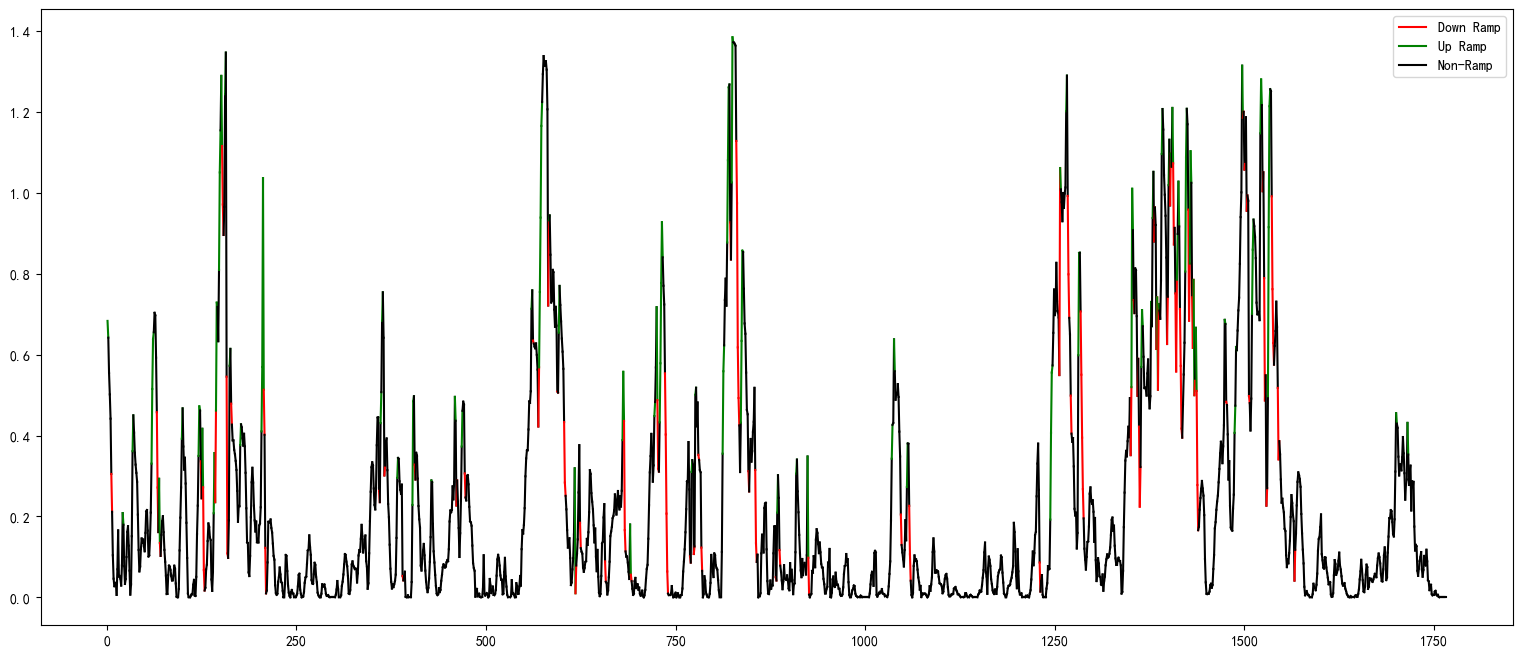

绿色线段数量: 107
红色线段数量: 105


In [26]:
#第二种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

summer_power = train_summer["power"]

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_xt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_xt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_xt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt2

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_xt2 = fit_line(summer_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt2)

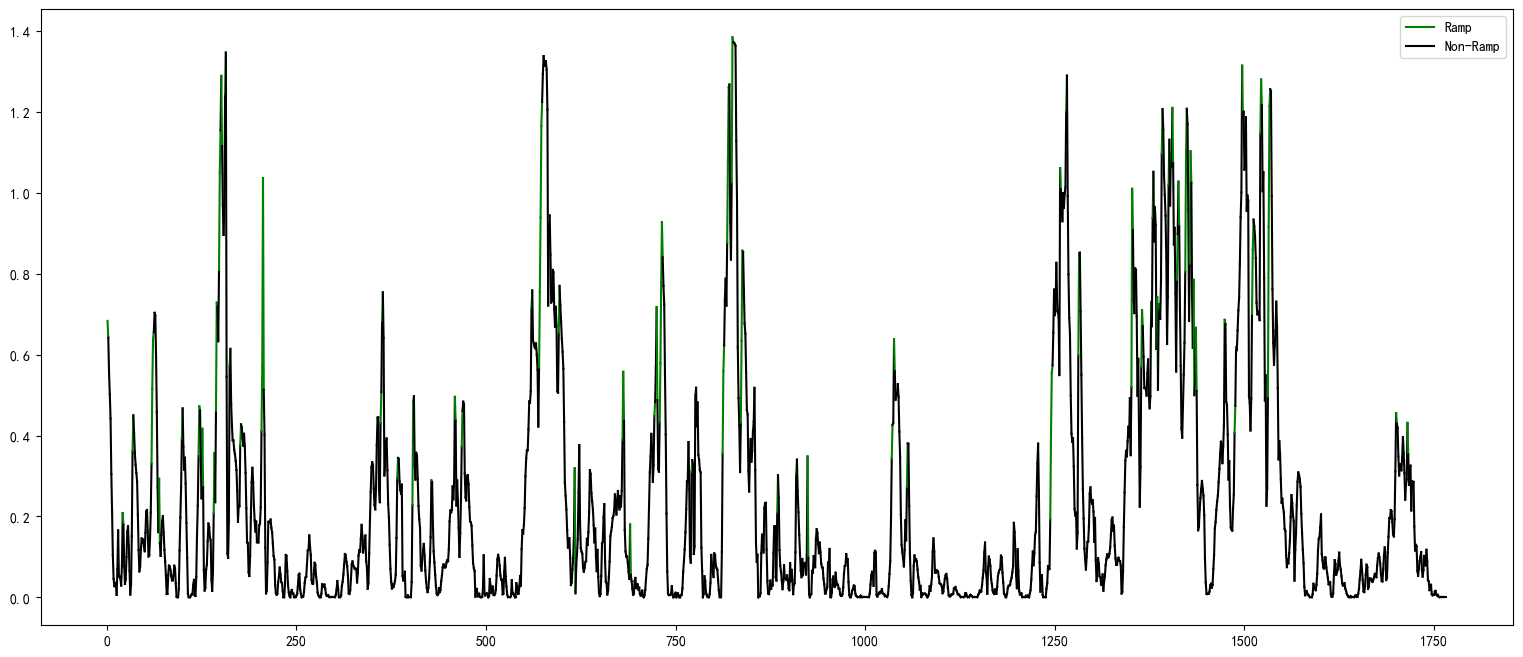

绿色线段数量: 107
红色线段数量: 0


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

summer_power = train_summer["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(summer_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_xt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_xt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_xt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_xt3 = fit_line(summer_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt3)

In [28]:
###对秋天的数据进行坡道检测

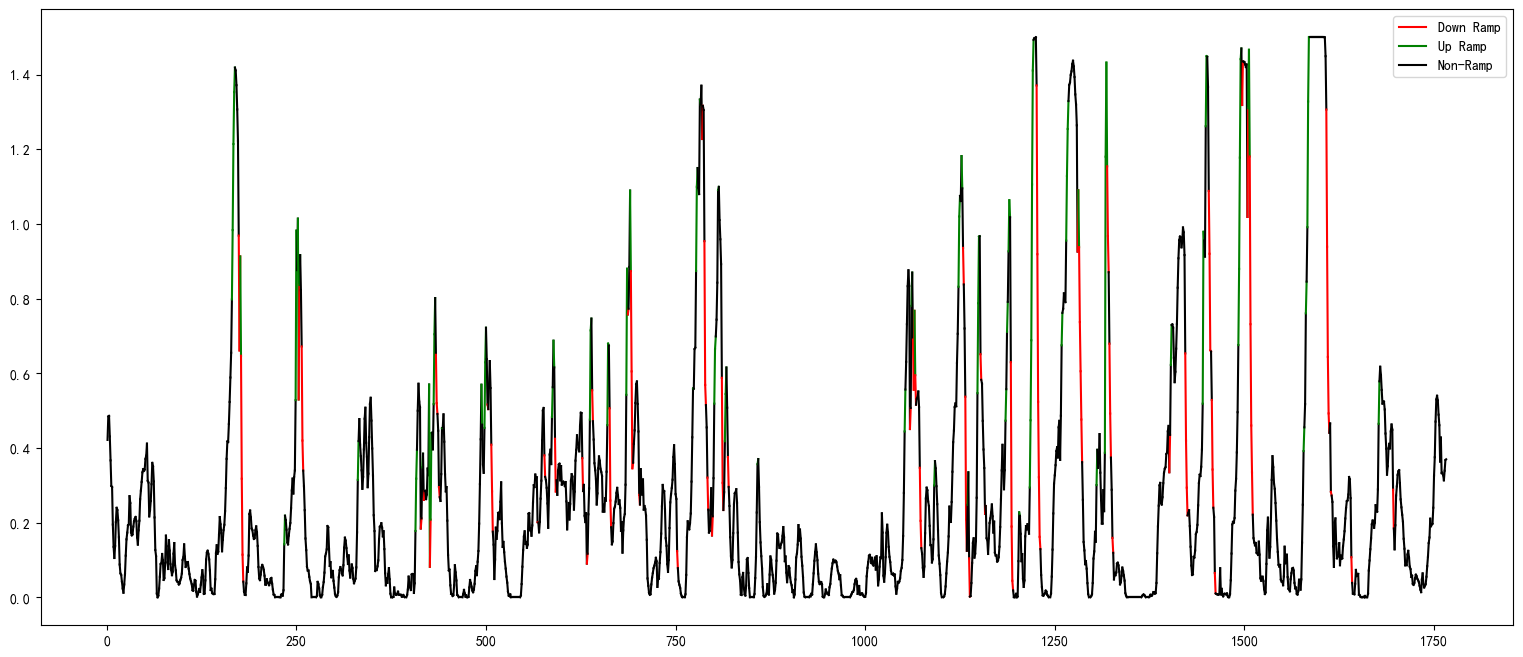

绿色线段数量: 89
红色线段数量: 93


In [29]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
autumn_power = train_autumn["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt1 = []  # 用于存储每个数据点的标签
    for i in range(0, len(data)):
        diff = (y[i] - y[i-1]) / time_interval
        if diff > threshold:
            colors.append('green')
            labels_qt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_qt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_qt1 = fit_line(autumn_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt1)

In [30]:
#对秋天的第二种坡道识别

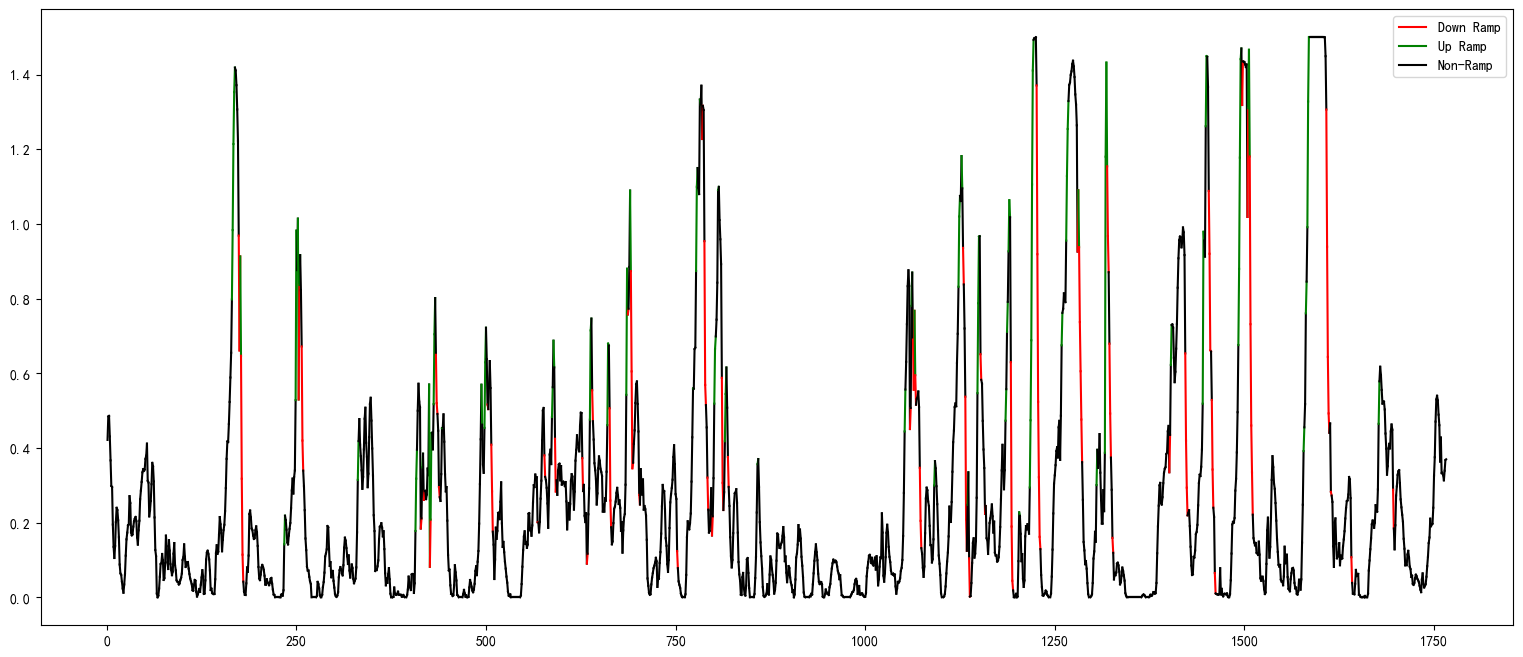

绿色线段数量: 89
红色线段数量: 93


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 取出第一列的元素
autumn_power = train_autumn["power"]
def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_qt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_qt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt2



threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_qt2 = fit_line(autumn_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt2)

In [32]:
#对秋天的第三种定义识别坡道

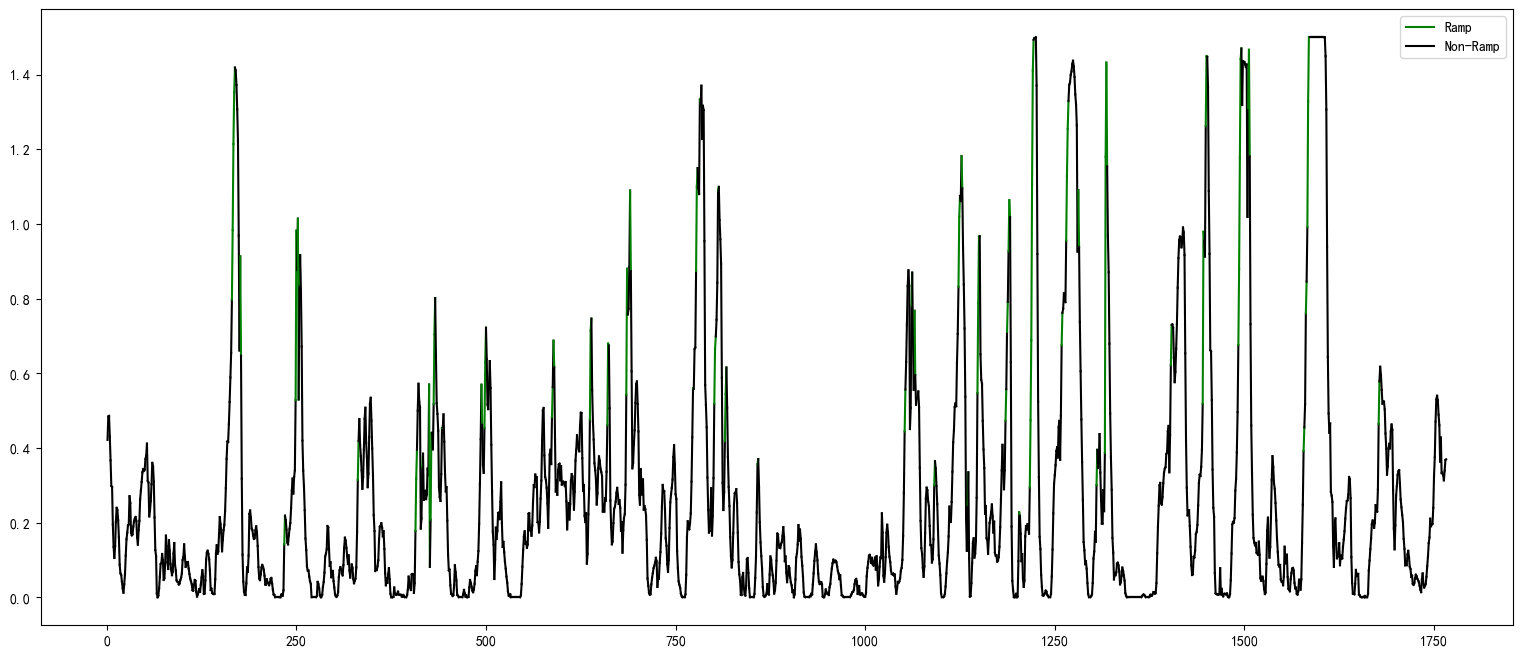

绿色线段数量: 89
红色线段数量: 0


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

autumn_power = train_autumn["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(autumn_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_qt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_qt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_qt3 = fit_line(autumn_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt3)

In [34]:
###对冬天的数据进行坡道检测

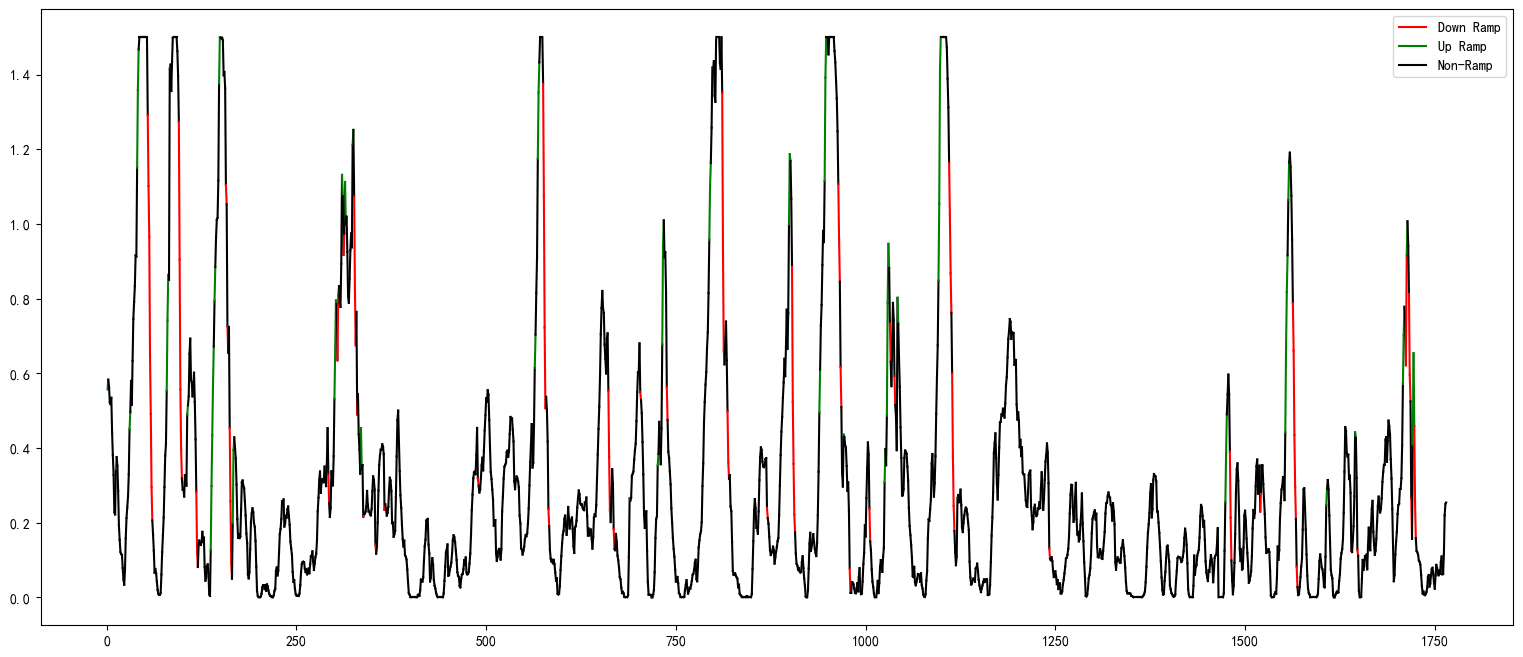

绿色线段数量: 66
红色线段数量: 81


In [35]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
winter_power =train_winter["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt1 = []  # 用于存储每个数据点的标签
    for i in range(0, len(data)):
        diff = (y[i] - y[i-1]) / time_interval
        if diff > threshold:
            colors.append('green')
            labels_dt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_dt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_dt1 = fit_line(winter_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt1)

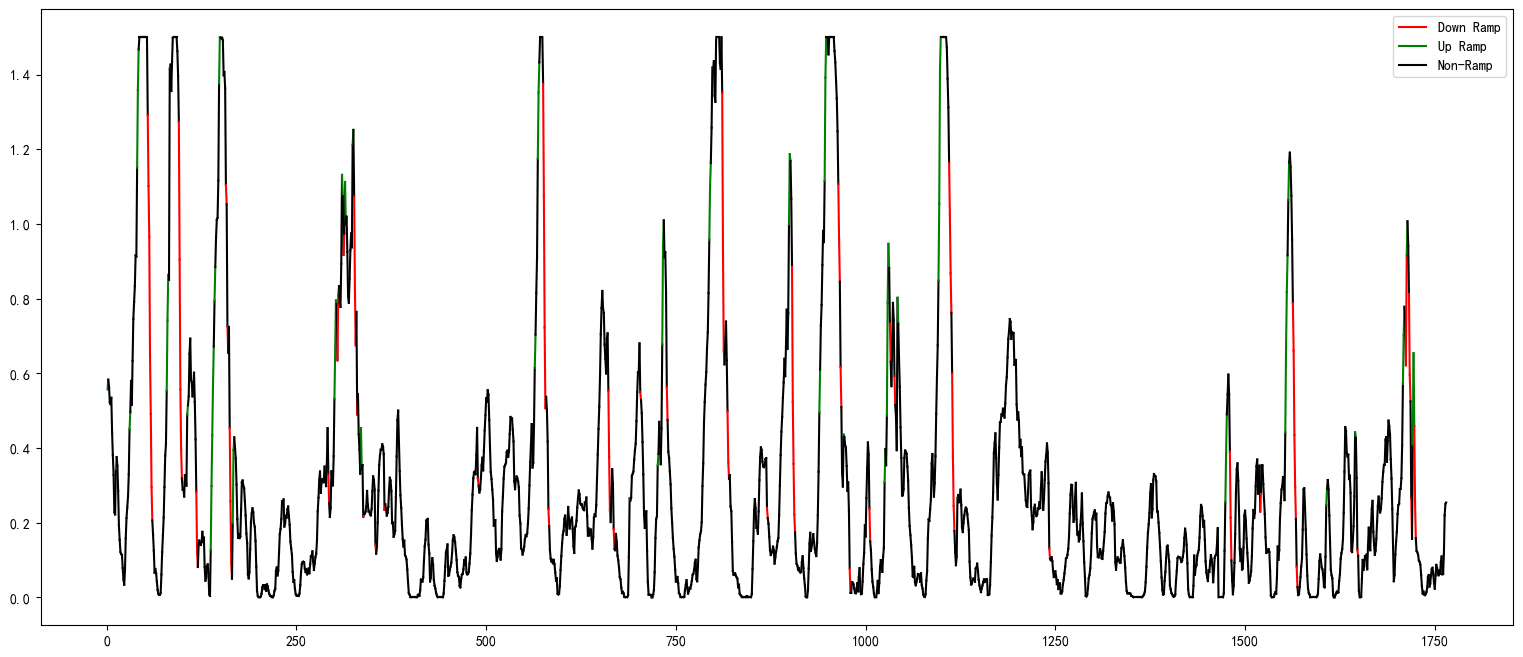

绿色线段数量: 66
红色线段数量: 81


In [36]:
#对冬天的第二种坡道识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

winter_power =train_winter["power"]
def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_dt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_dt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt2


threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_dt2 = fit_line(winter_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt2)

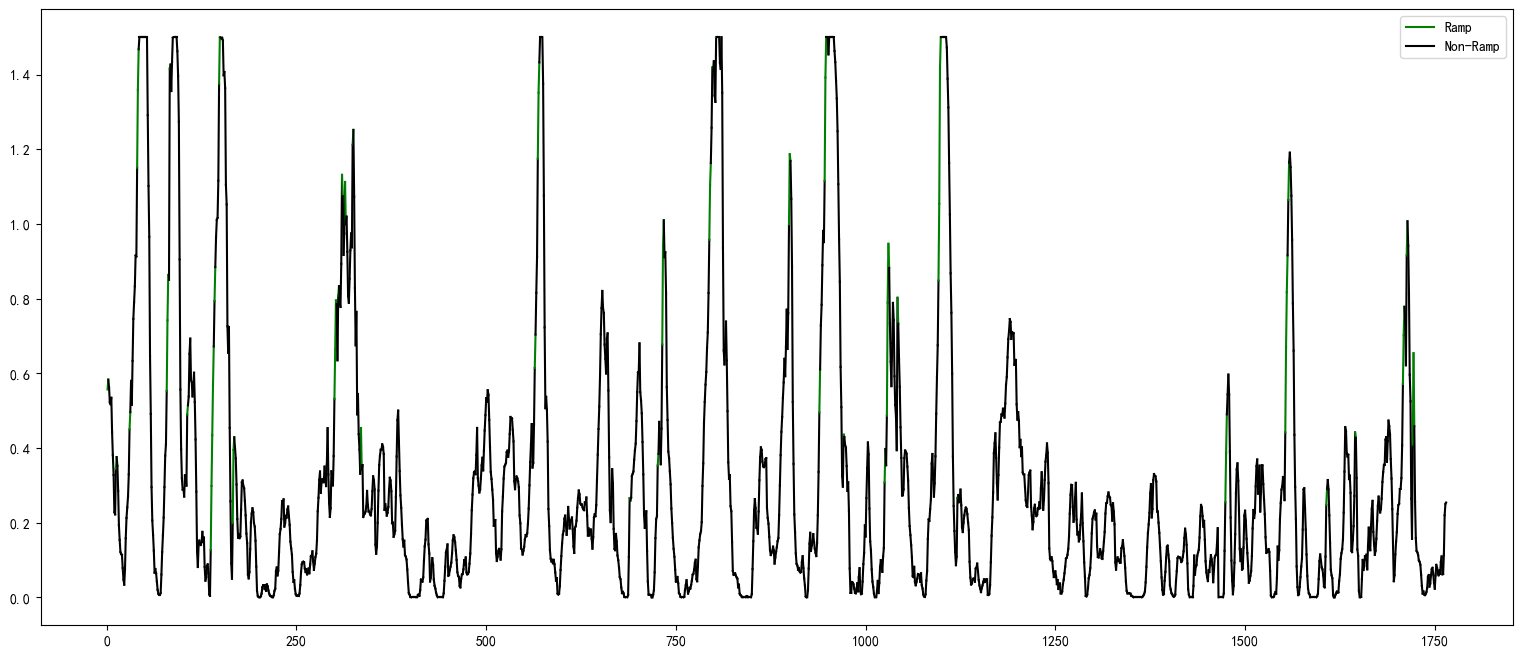

绿色线段数量: 66
红色线段数量: 0


In [37]:
#对冬天的第三种定义坡道识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

winter_power =train_winter["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(winter_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, time_interval, threshold):
    x = x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_dt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_dt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_dt3 = fit_line(winter_power, time_interval, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt3)

In [38]:
###对测试集使用第三种定义进行坡道识别

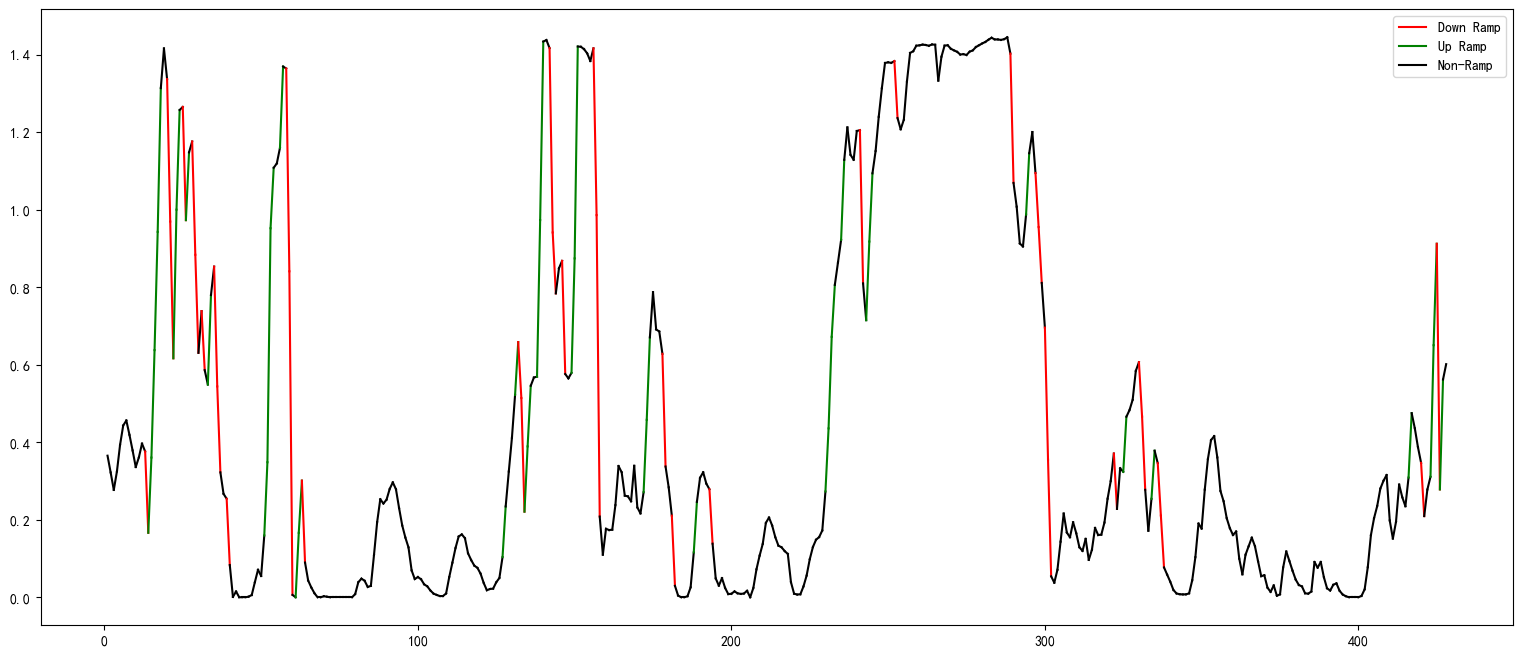

绿色线段数量: 38
红色线段数量: 37


In [39]:
#春天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_spring_power = test_spring["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ctt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ctt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ctt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ctt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ctt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_ctt1 = fit_line(test_spring_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ctt1)

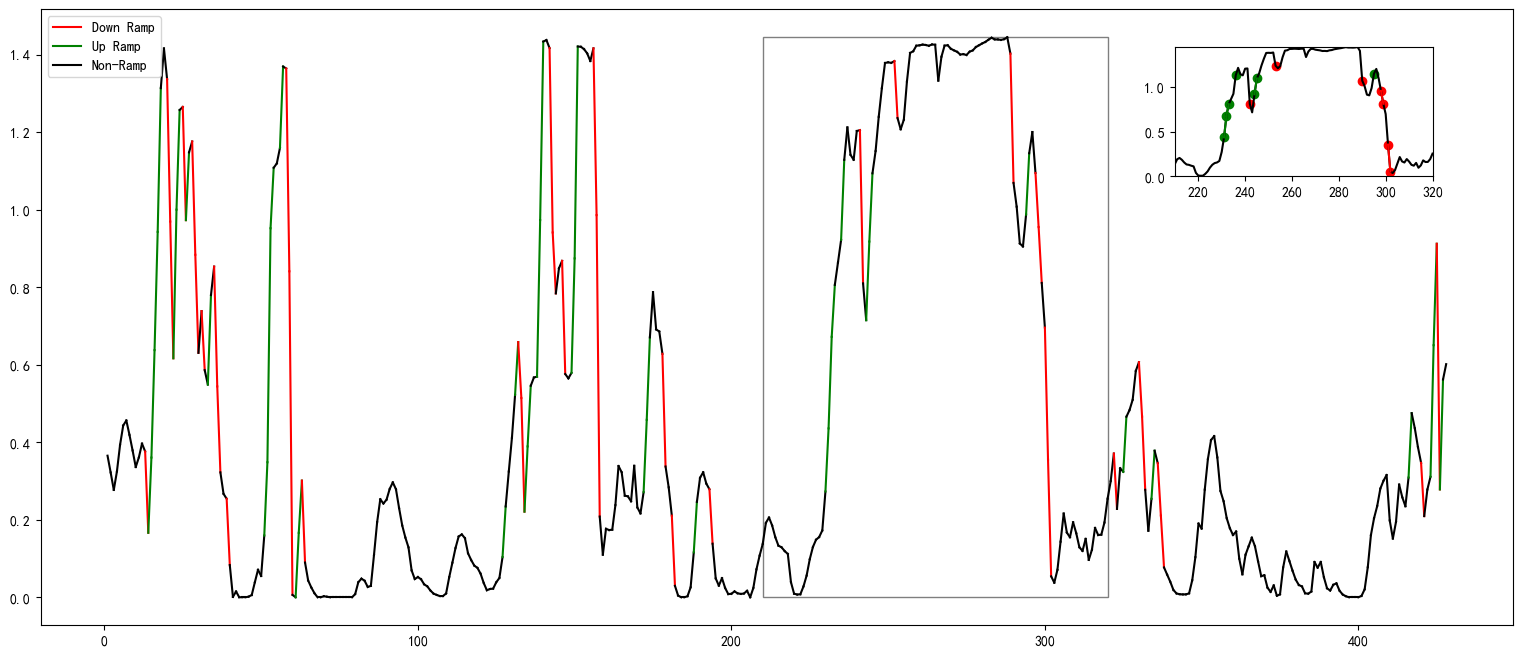

绿色线段数量: 38
红色线段数量: 37


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 取出第一列的元素
test_spring_power = test_spring["power"]

def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ctt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) / time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ctt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ctt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ctt1.append(0)

    # 绘制线条
    fig, ax = plt.subplots(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        ax.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    ax.plot([], [], color='red', linestyle='-', label='Down Ramp')
    ax.plot([], [], color='green', linestyle='-', label='Up Ramp')
    ax.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    ax.legend()

    # 放大特定区域
    # 设置放大图的宽度和高度
    axins = inset_axes(ax, width="50%", height="60%", loc='upper right',
                       bbox_to_anchor=(0.6, 0.6, 0.35, 0.35), bbox_transform=ax.transAxes)
    x1, x2, y1, y2 = 210, 320, min(y), max(y)  # 定义放大区域的x和y范围
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.plot(x[x1-1:x2], y[x1-1:x2], color='black')  # 绘制放大的折线图

    # 在放大区域中标注绿色的圆点并用绿色线条连接
    for i in range(x1, x2):
        if colors[i-1] == 'green':
            axins.scatter(x[i], y[i], color='green')
            if i < x2 and colors[i] == 'green':
                axins.plot([x[i], x[i+1]], [y[i], y[i+1]], color='green')

    # 在放大区域中标注红色的圆点并用红色线条连接
    for i in range(x1, x2):
        if colors[i-1] == 'red':
            axins.scatter(x[i], y[i], color='red')
            if i < x2 and colors[i] == 'red':
                axins.plot([x[i], x[i+1]], [y[i], y[i+1]], color='red')

    # 连接放大区域和主图的线
    ax.indicate_inset_zoom(axins, edgecolor="black")
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count, labels_ctt1

# 调用函数并获取颜色计数
time_interval = 4
threshold = 0.03
green_count, red_count, labels_ctt1 = fit_line(test_spring_power, time_interval, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")

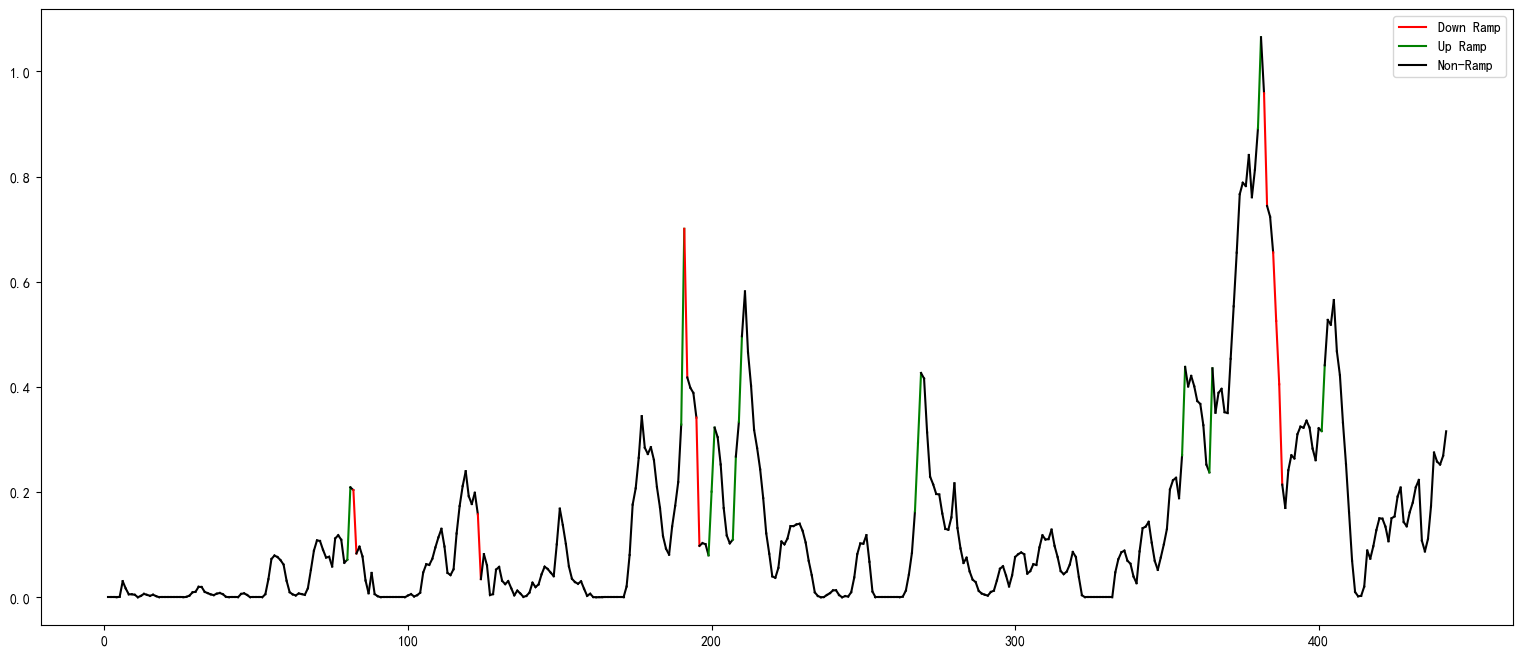

绿色线段数量: 12
红色线段数量: 8


In [31]:
#夏天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_summer_power =test_summer["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_xtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_xtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_xtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_xtt1 = fit_line(test_summer_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xtt1)

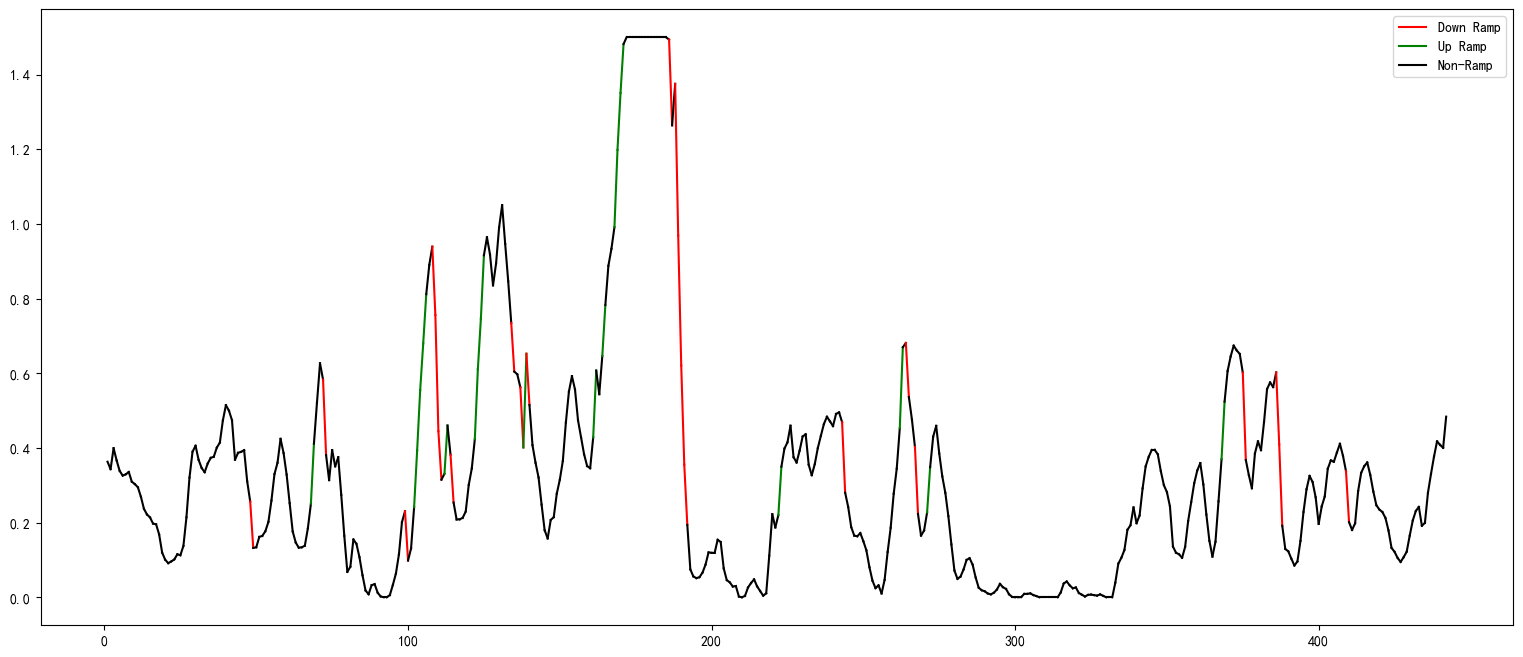

绿色线段数量: 19
红色线段数量: 22


In [32]:
#秋天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_autumn_power =test_autumn["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_qtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_qtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_qtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_qtt1 = fit_line(test_autumn_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qtt1)

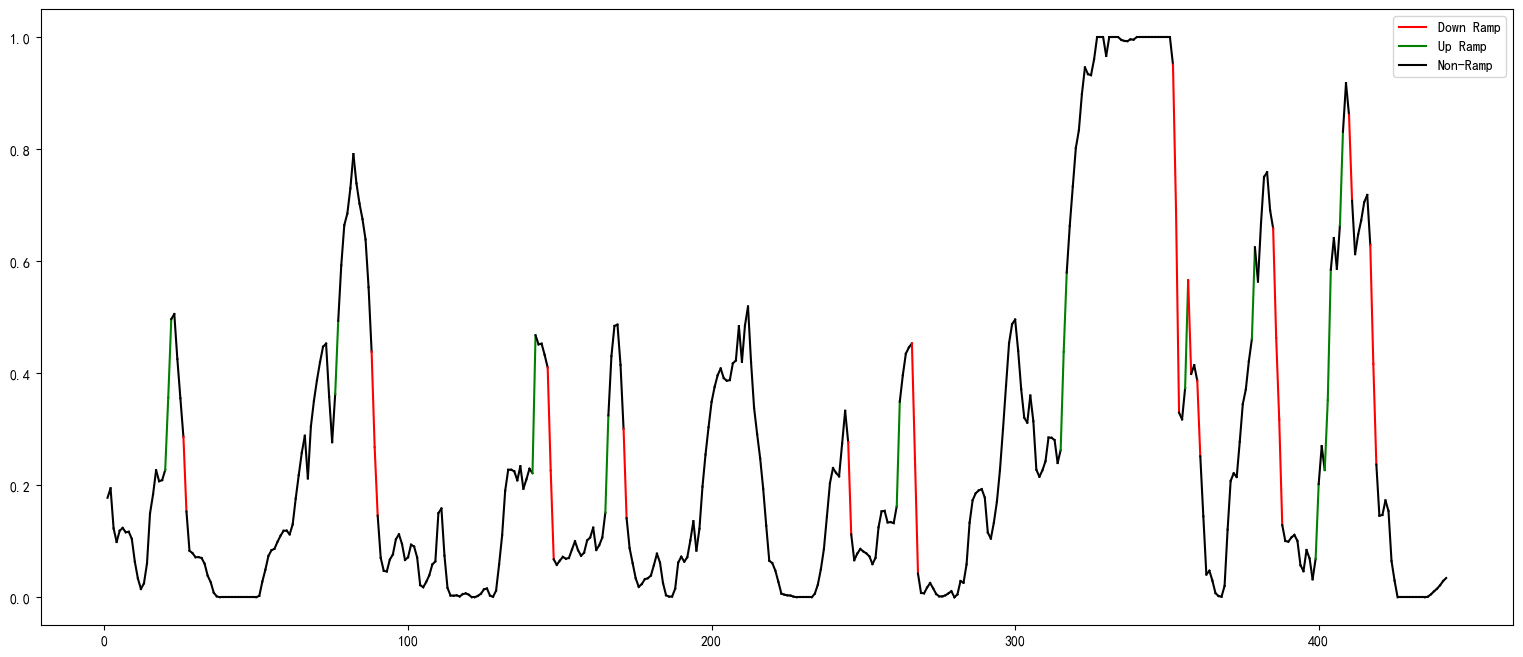

绿色线段数量: 14
红色线段数量: 19


In [33]:
#冬天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_winter_power = [row[0] for row in scaler_test_winter]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_dtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_dtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_dtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_dtt1 = fit_line(test_winter_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dtt1)

In [34]:
labels_ct1=labels_ct1+[0]
labels_xt1=labels_xt1+[0]

In [35]:
###选择第一种坡道识别对训练集进行标签标记
train_spring["labels"]=labels_ct1
train_spring.loc[train_spring['labels'] == -1, 'labels'] = 2
train_summer["labels"]=labels_xt1
train_summer.loc[train_summer['labels'] == -1, 'labels'] = 2
train_autumn["labels"]=labels_qt1
train_autumn.loc[train_autumn['labels'] == -1, 'labels'] = 2
train_winter["labels"]=labels_dt1
train_winter.loc[train_winter['labels'] == -1, 'labels'] = 2
train_winter

power  windspeed        hum     pressure  labels
0     0.556730   7.874127  67.665474   995.643984       2
1     0.582977   8.010701  66.120928   994.901328       0
2     0.562457   7.918826  62.835844   994.461719       0
3     0.521884   7.721948  64.779062   994.047031       0
4     0.517060   7.707475  67.821816   993.828047       0
...        ...        ...        ...          ...     ...
1760  0.062421   4.002718  58.324739  1004.713125       0
1761  0.114887   4.725828  54.667400  1004.192109       0
1762  0.219597   5.821859  49.216859  1003.389531       0
1763  0.250008   6.101761  36.769824  1002.373984       0
1764  0.253911   6.129780  35.966384  1001.656641       0

[1765 rows x 5 columns]

In [36]:
#将得到的训练集和测试集保存至文档中
train_spring.to_excel(r'D:\article\Jilin_train_spring.xlsx', index=False, engine='openpyxl')
train_summer.to_excel(r'D:\article\Jilin_train_summer.xlsx', index=False, engine='openpyxl')
train_autumn.to_excel(r'D:\article\Jilin_train_autumn.xlsx', index=False, engine='openpyxl')
train_winter.to_excel(r'D:\article\Jilin_train_winter.xlsx', index=False, engine='openpyxl')

In [37]:
labels_ctt1=labels_ctt1+[0]
labels_xtt1=labels_xtt1+[0]
labels_qtt1=labels_qtt1+[0]
labels_dtt1=labels_dtt1+[0]

In [38]:
###选择第一种坡道识别对测试集进行标签标记
test_spring["labels"]=labels_ctt1
test_spring.loc[test_spring['labels'] == -1, 'labels'] = 2
test_summer["labels"]=labels_xtt1
test_summer.loc[test_summer['labels'] == -1, 'labels'] = 2
test_autumn["labels"]=labels_qtt1
test_autumn.loc[test_autumn['labels'] == -1, 'labels'] = 2
test_winter["labels"]=labels_dtt1
test_winter.loc[test_winter['labels'] == -1, 'labels'] = 2
test_winter

power  windspeed        hum     pressure  labels
1765  0.266533   6.218737  35.589634  1001.230078       0
1766  0.291851   6.387521  36.212985  1001.614375       0
1767  0.184497   5.496956  37.112380  1001.571328       0
1768  0.148202   5.120771  46.338404  1002.177656       0
1769  0.178272   5.407605  46.990993  1002.203359       0
...        ...        ...        ...          ...     ...
2202  0.016034   3.093603  41.825455  1001.565547       0
2203  0.022975   3.233540  44.908966  1001.625156       0
2204  0.032253   3.417685  52.189984  1002.048438       0
2205  0.043572   3.643146  52.280977  1002.048438       0
2206  0.051562   3.802641  53.871035  1002.404609       0

[442 rows x 5 columns]

In [49]:
#将得到的训练集和测试集保存至文档中
test_spring.to_excel(r'D:\article\Jilin_test_spring.xlsx', index=False, engine='openpyxl')
test_summer.to_excel(r'D:\article\Jilin_test_summer.xlsx', index=False, engine='openpyxl')
test_autumn.to_excel(r'D:\article\Jilin_test_autumn.xlsx', index=False, engine='openpyxl')
test_winter.to_excel(r'D:\article\Jilin_test_winter.xlsx', index=False, engine='openpyxl')